样本数量为100000


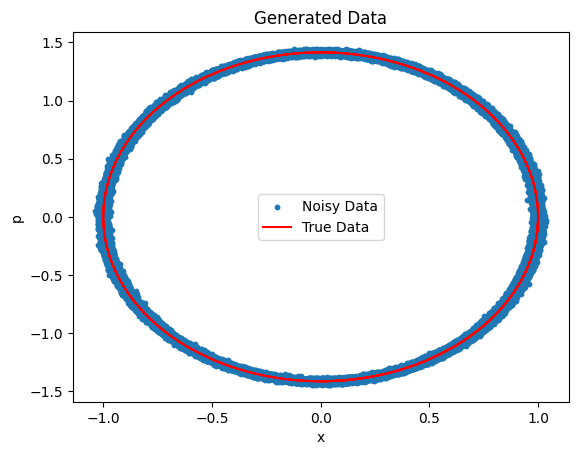

In [61]:
# 读取数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('harmonic_oscillator_trajectory.csv')
x_ture = data['x'].to_numpy()
y_true = data['p'].to_numpy()
N = x_ture.shape[0]

# 数据添加噪声
np.random.seed(42)

noise1 = np.random.normal(0, 0.01, size=N)  
noise2 = np.random.normal(0, 0.01, size=N)  
x = x_ture + noise1
y = y_true + noise2                       

print(f'样本数量为{N}')
# 可视化数据
plt.scatter(x, y, s=10, label="Noisy Data")
plt.plot(x_ture, y_true, color='r', label="True Data")
plt.legend()
plt.title("Generated Data")
plt.xlabel("x")
plt.ylabel("p")
plt.show()

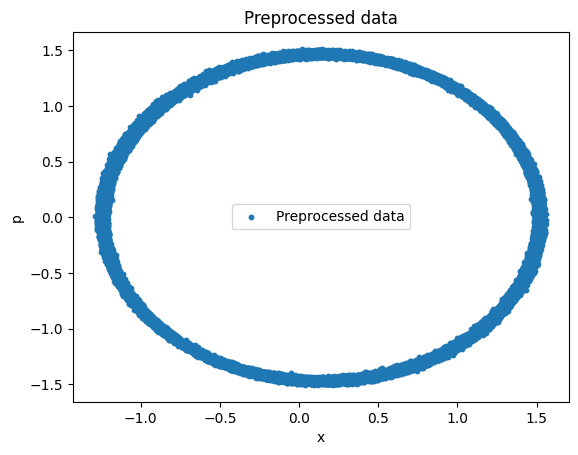

In [62]:
# 数据预处理

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = np.vstack((x, y)).T  # 组合成二维数据 (n_samples, n_features)
data_true = np.vstack((x_ture,y_true)).T

# 标准化数据
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# PCA 和白化
pca = PCA(whiten=True)  # whiten=True 启用白化
data_pca = pca.fit_transform(data_standardized)

# 可视化数据
plt.scatter(data_pca[:,0], data_pca[:,1], s=10, label="Preprocessed data")

plt.legend()
plt.title("Preprocessed data")
plt.xlabel("x")
plt.ylabel("p")
plt.show()

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim


x = data_pca[:,0]
y = data_pca[:,1]

# 转换为 PyTorch 张量
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 定义神经网络
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),       # 第一隐藏层
            nn.Sigmoid(),           # 激活函数
            nn.Linear(64, 64),      # 第二隐藏层
            nn.Sigmoid(),           # 激活函数
            nn.Linear(64, 1)        # 输出层
        )
    
    def forward(self, x):
        return self.model(x)

# 实例化模型
model = FeedForwardNN()


# 自定义损失函数
def custom_loss(y_pred, y_true):
    mse = torch.mean((y_true - y_pred) ** 2)                 # 均方误差
    regularization = 0.01 * torch.mean(y_pred ** 2)          # 正则化项
    return mse + regularization

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练设置
epochs = 200
batch_size = int(N/epochs)
dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 开始训练
train_loss_history = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()                # 梯度清零
        y_pred = model(batch_x)              # 前向传播
        loss = custom_loss(y_pred, batch_y)  # 计算损失
        loss.backward()                      # 反向传播
        optimizer.step()                     # 更新权重
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    train_loss_history.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")



# 绘制训练过程中的损失变化
plt.plot(train_loss_history, label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 模型预测
y_pred = model(x_tensor).detach().numpy()

# 可视化结果
plt.scatter(x, y, s=10, label="Noisy Data")
plt.plot(x, y_true, color='r', label="True Function: $y = x^2$")
plt.plot(x, y_pred, color='g', label="Predicted Function")
plt.legend()
plt.title("Model Prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x500 and 1x64)